In [1]:
import zipfile
import os

In [2]:
# Define the path to the zip file and the extraction directory
zip_file_path = 'FaceExp.zip'
extraction_dir = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List the contents of the extraction directory
extracted_files = os.listdir(extraction_dir)
print(extracted_files)

['FaceExp']


In [3]:
# prompt: how to read the data and load images from FaceExp

import os
from PIL import Image
import numpy as np

# Define the path to the extracted FaceExp directory
faceexp_dir = '/content/FaceExp'

# Initialize lists to store image data and labels
images = []
labels = []

# Iterate through the subdirectories (emotions) in FaceExp
for emotion_dir in os.listdir(faceexp_dir):
  emotion_path = os.path.join(faceexp_dir, emotion_dir)
  if os.path.isdir(emotion_path):
    # Iterate through the image files in each emotion directory
    for image_file in os.listdir(emotion_path):
      image_path = os.path.join(emotion_path, image_file)
      # Open the image and convert it to grayscale
      image = Image.open(image_path).convert('L')
      # Resize the image to a desired size (e.g., 48x48)
      image = image.resize((48, 48))
      # Convert the image to a NumPy array and append it to the list
      images.append(np.array(image))
      # Append the corresponding emotion label to the list
      labels.append(emotion_dir)

# Convert the lists to NumPy arrays for further processing
images = np.array(images)
labels = np.array(labels)

# Print the shapes of the image and label arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (757, 48, 48)
Labels shape: (757,)


In [4]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.regularizers import l2

In [7]:
dataset_folder_path = '/content/FaceExp'

image_label_pairs=[]
target_width, target_height = 224, 224
valid_image_extensions = ['.jpg', '.jpeg', '.png'] # Define valid extensions

# Example: Read and process each image in 'dataset' folder
for label_name in os.listdir(dataset_folder_path):
  file_path = os.path.join(dataset_folder_path, label_name)

    # Check if it's a directory
  if os.path.isdir(file_path): # Fixed indentation here
    print(f"Processing images in: {file_path}")

        # Iterate through the files in the subdirectory
    for image_name in os.listdir(file_path):
      image_path = os.path.join(file_path, image_name)

      if any(image_path.endswith(ext) for ext in valid_image_extensions): # Check for valid image extensions
        image = cv2.imread(image_path)

        if image is not None:
                    # Resize the image to the target dimensions
          resized_image = cv2.resize(image, (target_width, target_height))

                    # Perform scaling (optional: normalize pixel values)
          resized_image = resized_image / 255.0  # Normalize pixel values to [0, 1]
          image_label_pairs.append((resized_image, label_name))

Processing images in: /content/FaceExp\Ahegao
Processing images in: /content/FaceExp\Angry
Processing images in: /content/FaceExp\Happy
Processing images in: /content/FaceExp\Neutral
Processing images in: /content/FaceExp\Sad
Processing images in: /content/FaceExp\Surprise


In [8]:
# Check the distribution of the samples across categories
category_counts = {}
for _, label in image_label_pairs:
    if label in category_counts:
        category_counts[label] += 1
    else:
        category_counts[label] = 1

for category, count in category_counts.items():
    print(f"Category '{category}': {count} images")

Category 'Ahegao': 114 images
Category 'Angry': 106 images
Category 'Happy': 118 images
Category 'Neutral': 206 images
Category 'Sad': 105 images
Category 'Surprise': 101 images


In [9]:
print(f"Total images found: {len(image_label_pairs)}")

Total images found: 750


In [10]:
image_label_pairs[68:69]

[(array([[[0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431],
          ...,
          [0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431]],
  
         [[0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431],
          ...,
          [0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431],
          [0.49803922, 0.43921569, 0.56078431]],
  
         [[0.50196078, 0.44313725, 0.56470588],
          [0.50196078, 0.44313725, 0.56470588],
          [0.50196078, 0.44313725, 0.56470588],
          ...,
          [0.50196078, 0.44313725, 0.56470588],
          [0.50196078, 0.44313725, 0.56470588],
          [0.50196078, 0.44313725, 0.56470588]],
  
         ...,
  
         [[0.18039216, 0.09411765, 0.11372549],
          [0.1

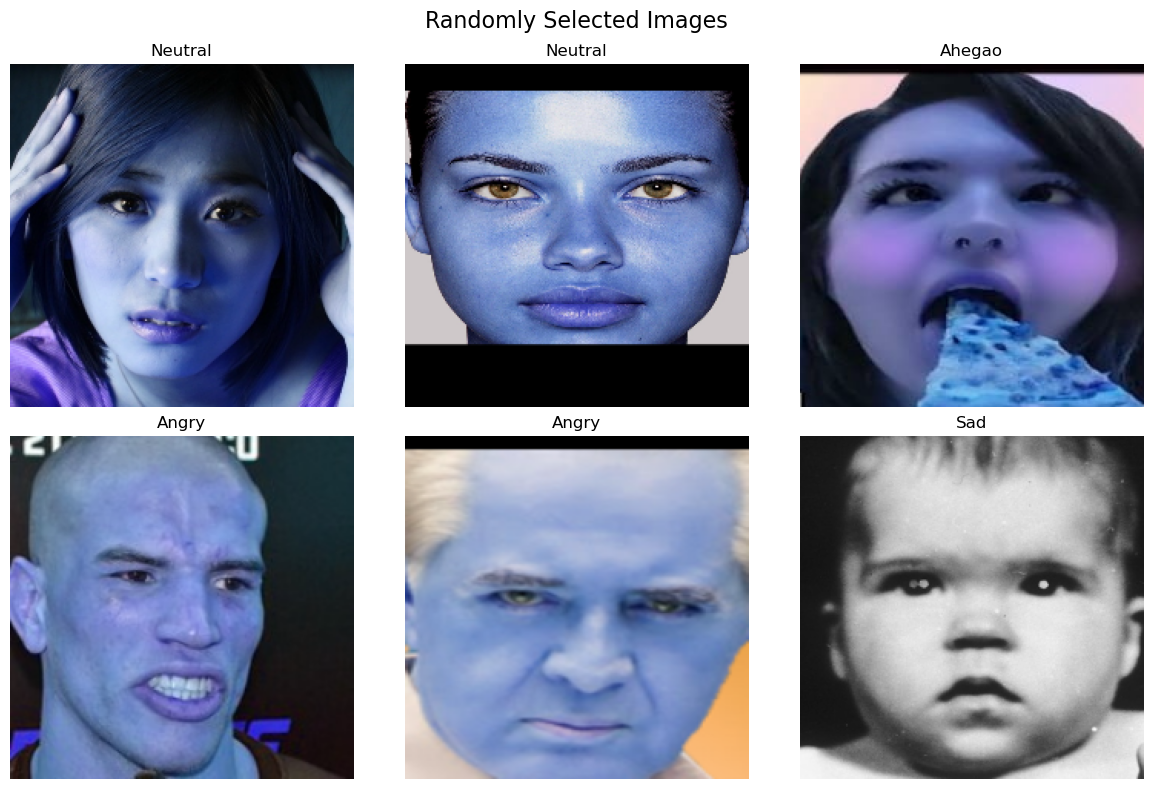

In [11]:
# Get the length of image_label_pairs
num_samples = len(image_label_pairs)

# Select 6 random indices
random_indices = np.random.choice(num_samples, size=6, replace=False)

# Visualize the random samples
plt.figure(figsize=(12, 8))
plt.suptitle('Randomly Selected Images', fontsize=16)

for i, index in enumerate(random_indices):
    image_data, label = image_label_pairs[index]

    # Convert from normalized float back to integer (assuming image is in [0, 1] range)
    image_to_visualize = (image_data * 255).astype(np.uint8)

    # Plot the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_to_visualize)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Extract labels from image_label_pairs
labels = [pair[1] for pair in image_label_pairs]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
encoded_labels = label_encoder.fit_transform(labels)

# Replace original labels with encoded labels in image_label_pairs
for i in range(len(image_label_pairs)):
    image_label_pairs[i] = (image_label_pairs[i][0], encoded_labels[i])




In [13]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(mapping)

{'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


In [14]:
# Convert image_label_pairs to numpy arrays
x = np.array([pair[0] for pair in image_label_pairs])
y = np.array([pair[1] for pair in image_label_pairs])

In [15]:
# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Using a basic ImageDataGenerator for validation and test sets
test_datagen = ImageDataGenerator()

# Fitting on training set
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

# Use basic generators for validation and test sets
val_generator = test_datagen.flow(x_val, y_val, batch_size=32)
test_generator = test_datagen.flow(x_test, y_test, batch_size=32)

In [17]:
#Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 302s 5us/step


In [18]:
base_model.trainable = False

In [19]:
num_classes = 6  # Number of unique labels in your dataset

model = Sequential()
model.add(base_model)  # Add the VGG16 base model
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with num_classes units

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [23]:

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.2516 - loss: 2.1744 - val_accuracy: 0.5446 - val_loss: 1.2952
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.5801 - loss: 1.1251 - val_accuracy: 0.5982 - val_loss: 1.0494
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.7093 - loss: 0.8066 - val_accuracy: 0.6250 - val_loss: 0.9769
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.7854 - loss: 0.5907 - val_accuracy: 0.6518 - val_loss: 0.9232
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1812s 113s/step - accuracy: 0.8547 - loss: 0.4634 - val_accuracy: 0.6786 - val_loss: 0.8730
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.9099 - loss: 0.3531 - val_accuracy: 0.6964 - val_loss: 0.8558
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.9010 - loss: 0.3481 - val_accuracy: 0.7321 - val_loss: 0.9147
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.9447 - loss: 0.2838 - val_accuracy: 0.7143 - val_l

In [24]:
# Make predictions
predictions = model.predict(x_val)
predicted_labels = np.argmax(predictions, axis=1)

# Check the shape of y_val and reshape if necessary
print(y_val.shape)
if y_val.ndim == 1:  # If y_val is 1D
    y_val = np.expand_dims(y_val, axis=1)  # Add a dimension

true_labels = np.argmax(y_val, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
(112,)


In [25]:
# Extract accuracy and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract loss and validation loss (optional, for plotting)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [26]:
# Best epoch accuracy
best_epoch_accuracy = max(train_acc)
print(f"Best epoch training accuracy: {best_epoch_accuracy:.4f}")

# Average accuracy
average_epoch_accuracy = sum(train_acc) / len(train_acc)
print(f"Average training accuracy: {average_epoch_accuracy:.4f}")


Best epoch training accuracy: 0.9848
Average training accuracy: 0.8289


In [27]:
# Best epoch validation accuracy
best_epoch_val_accuracy = max(val_acc)
print(f"Best epoch validation accuracy: {best_epoch_val_accuracy:.4f}")

# Average validation accuracy
average_epoch_val_accuracy = sum(val_acc) / len(val_acc)
print(f"Average validation accuracy: {average_epoch_val_accuracy:.4f}")

Best epoch validation accuracy: 0.7321
Average validation accuracy: 0.6674


In [28]:
# Unfreeze the last few layers of the VGG16 base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [29]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [30]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)


In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [32]:
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/20


C:\Users\venip\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.2075 - loss: 3.0991 - val_accuracy: 0.2589 - val_loss: 2.6922 - learning_rate: 1.0000e-05
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.2145 - loss: 2.9438 - val_accuracy: 0.2946 - val_loss: 2.5476 - learning_rate: 1.0000e-05
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.3353 - loss: 2.6601 - val_accuracy: 0.4911 - val_loss: 2.4355 - learning_rate: 1.0000e-05
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.3151 - loss: 2.6156 - val_accuracy: 0.5000 - val_loss: 2.3347 - learning_rate: 1.0000e-05
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.3938 - loss: 2.5077 - val_accuracy: 0.5536 - val_loss: 2.2356 - learning_rate: 1.0000e-05
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 119s 7s/step - accuracy: 0.4302 - loss: 2.4471 - val_accuracy: 0.5536 - val_loss: 2.2097 - learning_rate: 1.0000e-05
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.5108 - loss: 2.2496 -

In [34]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Training loss: {test_loss}')
print(f"Test accuracy: {test_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.6076 - loss: 1.8336
Training loss: 1.8274909257888794
Test accuracy: 0.6283


In [35]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Training loss: {train_loss}')
print(f'Training accuracy: {train_accuracy}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.7019 - loss: 1.7515
Training loss: 1.7184135913848877
Training accuracy: 0.7028571367263794


In [43]:
model.save('model.h5')